# Develop segmentor2 with example

In [1]:
import numpy as np
import dask.array as da
#import subprocess
import tempfile
from pathlib import Path
import os
cwd = os.getcwd()
import tempfile
import logging
from types import SimpleNamespace
import tqdm #progress bar in iterations
import pandas as pd

from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch
import torch.nn as nn
import albumentations as alb
import albumentations.pytorch

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO)
import tifffile

Settings

In [3]:
data_vol_norm_process = "mean_stdev_3" #standard clipping

cuda_device=0

nn1_loss_criterion='DiceLoss'
nn1_eval_metric='MeanIoU'
nn1_lr=1e-5
nn1_max_lr=3e-2

# nn1_epochs = 15
nn1_epochs = 5 # debug

nn1_batch_size = 2
nn1_num_workers = 1

nn1_models_class_generator = [{
'class':'smp', #smp: segmentation models pytorch
'arch': 'U_Net',
'encoder_name': 'resnet34',
'encoder_weights': 'imagenet', # TODO: support for using existing models (loading)
'in_nchannels':1,
'nclasses':3,
}]

nn1_axes_to_models_indices = [0,1,2] # By default use the same model for all axes
# To use different models, use [0,1,2] for model0 along z, model1 along y, and model2 along x

nn2_MLP_models_class_generator = {
    "nn2_hidden_layer_sizes" : "10,10",
    "nn2_activation": 'tanh',
    "nn2_out_nclasses": 3
}

nn2_max_iter = 1000
nn2_ntrain = 262144 #Note that this is not a MLPClassifier parameter

temp_data_outdir = None

In [4]:
cuda_str = f"cuda:{cuda_device}"

In [5]:
#segm2 = lgs2.cMultiAxisRotationsSegmentor2.create_simple_separate_models_per_axis(3)

trainlabels max value is 2, so 3 classes

In [6]:
nclasses =3

setup NN1 models

In [7]:
nn1_dict_gen = {'class':'smp', #smp: segmentation models pytorch
    'arch': 'U_Net',
    'encoder_name': 'resnet34',
    'encoder_weights': 'imagenet', # TODO: support for using existing models (loading)
    'in_nchannels':1, #greyscale
    'nclasses':nclasses,
}


In [8]:
nn1_models_class_generator = [nn1_dict_gen,
    nn1_dict_gen.copy(),
    nn1_dict_gen.copy()
]

In [9]:
nn1_models_class_generator

[{'class': 'smp',
  'arch': 'U_Net',
  'encoder_name': 'resnet34',
  'encoder_weights': 'imagenet',
  'in_nchannels': 1,
  'nclasses': 3},
 {'class': 'smp',
  'arch': 'U_Net',
  'encoder_name': 'resnet34',
  'encoder_weights': 'imagenet',
  'in_nchannels': 1,
  'nclasses': 3},
 {'class': 'smp',
  'arch': 'U_Net',
  'encoder_name': 'resnet34',
  'encoder_weights': 'imagenet',
  'in_nchannels': 1,
  'nclasses': 3}]

In [10]:
def create_nn1_ptmodel_from_class_generator(nn1_cls_gen_dict: dict):
    # get segm model from dictionary item
    model0=None

    if nn1_cls_gen_dict['class'].lower()=='smp': #unet, AttentionNet (manet) and fpn
        #Segmentation models pytorch
        arch = nn1_cls_gen_dict['arch'].lower()
        if arch=="unet" or arch=="u_net":
            NN_class = smp.Unet
        elif arch=="manet":
            model0 = smp.MAnet
        elif arch=="fpn":
            model0 = smp.FPN
        else:
            raise ValueError(f"arch:{arch} not valid.")
        
        model0 = NN_class(
            encoder_name = nn1_cls_gen_dict['encoder_name'],
            encoder_weights = nn1_cls_gen_dict['encoder_weights'],
            in_channels = nn1_cls_gen_dict['in_nchannels'],
            classes = nn1_cls_gen_dict['nclasses'],
            #activation = "sigmoid" # Whether to use activation or not, depends whether the loss function require slogits or not
            activation = None
            )
    else:
        raise ValueError(f"class {nn1_cls_gen_dict['class']} not supported.")
    
    # TODO: add other 2D model support, not just SMPs

    return model0

In [11]:
NN1_models = [ create_nn1_ptmodel_from_class_generator(x).to(f"cuda:{cuda_device}") for x in nn1_models_class_generator]

In [12]:
NN1_models

[Unet(
   (encoder): ResNetEncoder(
     (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
       (1): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [13]:
len(NN1_models)

3

In [14]:
nn1_axes_to_models_indices = [0,1,2]

In [15]:
idx_models = np.unique(nn1_axes_to_models_indices)
idx_models

array([0, 1, 2])

# Load data and create dataloaders

load data

In [16]:
data_labels_fn=[
    ("./test_data/TS_0005_crop.tif", "./test_data/TS_0005_ribos_membr_crop.tif"),
]

traindatas=[]
trainlabels=[]

for datafn0, labelfn0 in data_labels_fn:
     #Make sure data and labels are curated in the correct data format
    traindatas.append(tifffile.imread(datafn0))
    trainlabels.append(tifffile.imread(labelfn0)) #In this case labels are already in uint8

In [17]:
print(trainlabels[0].max())

2


Normalise data to "mean_stdev_3"

In [18]:
traindata_list0=[]

# Clip data to -3*stdev and +3*stdev and normalises to values between 0 and 1
for d0 in traindatas:
    d0_mean = np.mean(d0)
    d0_std = np.std(d0)

    if d0_std==0:
        raise ValueError("Error. Stdev of data volume is zero.")
    
    d0_corr = (d0.astype(np.float32) - d0_mean) / d0_std
    d0_corr = (np.clip(d0_corr, -3.0, 3.0) +3.0) / 6.0
    
    traindata_list0.append(d0_corr*255)

In [19]:
traindata_list = [ t.astype(np.uint8) for t in traindata_list0]

In [20]:
len(traindata_list)

1

In [21]:
traindata_list[0].shape

(256, 256, 256)

In [22]:
traindata_list[0].dtype

dtype('uint8')

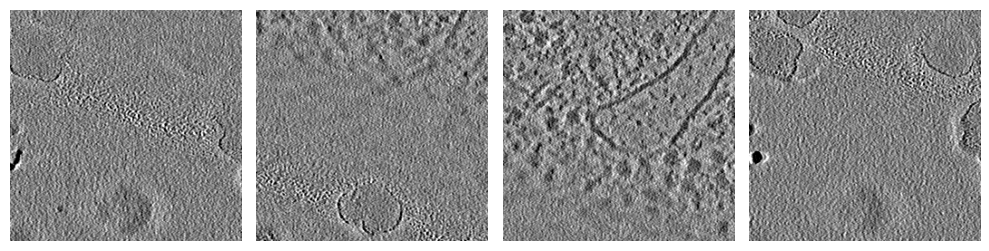

In [23]:
# view some slices to ensure the data is properly loaded
import random
randomints= np.random.default_rng().permutation(256)

fig, axs = plt.subplots(1, 4, figsize=(10,5))
#fig.tight_layout()
for i in range(4):
    ir = randomints[i]
    axs[i].imshow(traindata_list[0][ir,:,:], cmap="gray", vmin=0, vmax=255)
    axs[i].set_axis_off()
plt.tight_layout()

Create datasets and dataloaders for each model

In [24]:
def get_train_augmentations_v0(h,w):

    def get_nearest_multiple_of_32(v):
        i32 = v//32
        return i32*32

    img_h, img_w = h,w

    img_h32, img_w32 = get_nearest_multiple_of_32(img_h),  get_nearest_multiple_of_32(img_w)
    assert img_h32>0 and img_w>0

    tfms0 =alb.Compose(
                [
                alb.RandomSizedCrop(
                    min_max_height= (img_h32//2, img_h32),
                    height=img_h32,
                    width=img_w32 ,
                    p=0.5,
                ),
                #Deciding what resizing augmentations is difficult not kowing what
                # sizes the images can be different

                alb.VerticalFlip(p=0.5),
                alb.RandomRotate90(p=0.5),
                alb.Transpose(p=0.5),
                alb.OneOf(
                    [
                        alb.ElasticTransform(
                            alpha=120, sigma=120 * 0.07, alpha_affine=120 * 0.04, p=0.5
                        ),
                        alb.GridDistortion(p=0.5),
                        alb.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
                    ],
                    p=0.5,
                ),
                alb.CLAHE(p=0.5),
                alb.OneOf([alb.RandomBrightnessContrast(p=0.5),alb.RandomGamma(p=0.5)], p=0.5),
                alb.pytorch.ToTensorV2()
                ]
            )
    return tfms0

In [25]:
# TODO: check
class NN1_train_input_dataset_along_axes(Dataset):
    def __init__(self, datavols_list, labelsvols_list, axes=[0,1,2], cuda_device_str=0):
        
        self.cuda_device_str = cuda_device_str
        self.datavols_list = datavols_list
        self.labelsvols_list = labelsvols_list
        self.axes = axes

        #given an idx number, retrive the item, axis, slice number and transform
        self._idx_to_item=[]
        self._idx_to_ax=[]
        self._idx_to_slicen=[]
        self._idx_to_tfms = []

        #total_slices=0
        for id, d0 in enumerate(datavols_list):
            for ia, ax0 in enumerate(axes):
                nslices=d0.shape[ax0]
                #total_slices+= nslices

                id0_to_item = [id]*nslices
                self._idx_to_item.extend(id0_to_item)

                ax0_to_item = [ax0]*nslices
                self._idx_to_ax.extend(ax0_to_item)

                slice_range = np.arange(0,nslices).tolist()
                self._idx_to_slicen.extend(slice_range)

                if ax0==0:
                    t0 = get_train_augmentations_v0( *d0[0,:,:].shape )
                elif ax0==1:
                    t0 = get_train_augmentations_v0( *d0[:,0,:].shape )
                elif ax0==2:
                    t0 = get_train_augmentations_v0( *d0[:,:,0].shape )
                else:
                    raise ValueError(f"ax0 {ax0} not valid")
                self._idx_to_tfms.extend([t0]*nslices)

        total_slices = len(self._idx_to_item)

        assert total_slices==len(self._idx_to_ax) and total_slices==len(self._idx_to_ax) and total_slices==len(self._idx_to_slicen) and total_slices==len(self._idx_to_tfms)

        self.len = total_slices


    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        
        it = self._idx_to_item[idx]
        ax = self._idx_to_ax[idx]
        slicen = self._idx_to_slicen[idx]
        tfms = self._idx_to_tfms[idx]
        
        if ax==0:
            data_slice = self.datavols_list[it][slicen,:,:]
            labels_slice = self.labelsvols_list[it][slicen,:,:]
        elif ax==1:
            data_slice = self.datavols_list[it][:,slicen,:]
            labels_slice = self.labelsvols_list[it][:,slicen,:]
        elif ax==2:
            data_slice = self.datavols_list[it][:,:,slicen]
            labels_slice = self.labelsvols_list[it][:,:,slicen]
        else:
            raise ValueError(f"ax {ax} not valid")

        assert data_slice.shape == labels_slice.shape

        # Apply transforms
        res =tfms(image=data_slice, mask=labels_slice)

        data=res['image']
        labels=res['mask']
        
        data= data.to(self.cuda_device_str).float()
        labels=labels.to(self.cuda_device_str).long()

        #return a tuple data, mask
        return data, labels

In [26]:
trainlabels_list = trainlabels

In [27]:
# Test createing a dataset
ds0 = NN1_train_input_dataset_along_axes(
    traindata_list,
    trainlabels_list,
    [1,2], # change axis as desired
    cuda_device
)

In [28]:
len(ds0._idx_to_tfms)

512

Visualise data and respective labels from datasets (no transforms applied)

i:0, datai shape:torch.Size([1, 256, 256]), type:torch.float32   label shape:torch.Size([256, 256]), type:torch.int64
i:1, datai shape:torch.Size([1, 256, 256]), type:torch.float32   label shape:torch.Size([256, 256]), type:torch.int64
i:2, datai shape:torch.Size([1, 256, 256]), type:torch.float32   label shape:torch.Size([256, 256]), type:torch.int64
i:3, datai shape:torch.Size([1, 256, 256]), type:torch.float32   label shape:torch.Size([256, 256]), type:torch.int64
i:4, datai shape:torch.Size([1, 256, 256]), type:torch.float32   label shape:torch.Size([256, 256]), type:torch.int64


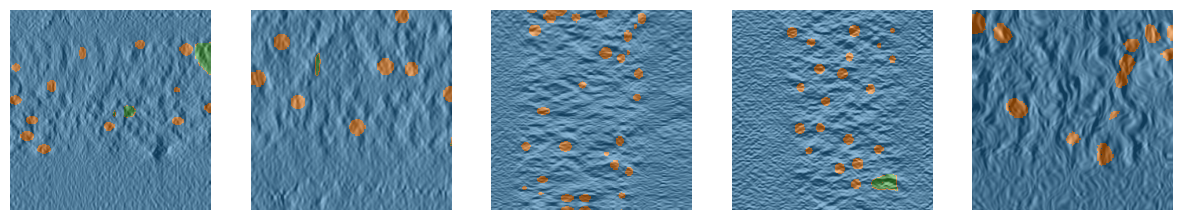

In [29]:
nimages=5
fig,axs = plt.subplots(1,nimages,figsize=(15,5))

randomints= np.random.default_rng().permutation(256)

for i in range(nimages):
    r0 = randomints[i]
    datai, labeli = ds0[r0]
    print(f"i:{i}, datai shape:{datai.shape}, type:{datai.dtype}   label shape:{labeli.shape}, type:{labeli.dtype}")
    datai=datai.detach().cpu().numpy()[0,:,:]
    labeli = labeli.detach().cpu().numpy()[:,:]
    axs[i].imshow(datai, cmap="gray")
    axs[i].imshow(labeli,cmap='tab10', alpha=0.5, vmax=10)
    axs[i].set_axis_off()

    if i==nimages-1:
        break

OK

In [30]:
nn1_axes_to_models_indices

[0, 1, 2]

In [31]:
#nn1_axes_to_models_indices = [0,1,2]

In [32]:
np.flatnonzero(
        np.array(nn1_axes_to_models_indices) == 2
    ).tolist()

[2]

In [33]:
dataloaders_train=[]
dataloaders_test=[]
for i in range(len(NN1_models)):
    #Gets the axes that the NN1 model is supposed to be used
    model_axes= np.flatnonzero(
        np.array(nn1_axes_to_models_indices) == i
    ).tolist()

    dl_train=None
    dl_test=None

    if len(model_axes)>0:

        ds0 = NN1_train_input_dataset_along_axes(
            traindata_list,
            trainlabels_list,
            model_axes,
            cuda_device
        )

        dset1, dset2 = torch.utils.data.random_split(ds0, [0.8,0.2])

        dl_train = DataLoader(dset1, batch_size=nn1_batch_size, shuffle=True)
        dl_test = DataLoader(dset2, batch_size=nn1_batch_size, shuffle=True)

    dataloaders_train.append(dl_train)
    dataloaders_test.append(dl_test)


In [34]:
len(dataloaders_train[0])

103

In [35]:
len(dataloaders_test[0])

26

In [36]:
dataloaders_train[0]

visualise some data and labels

i:0, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:1, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:2, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:3, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:4, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64


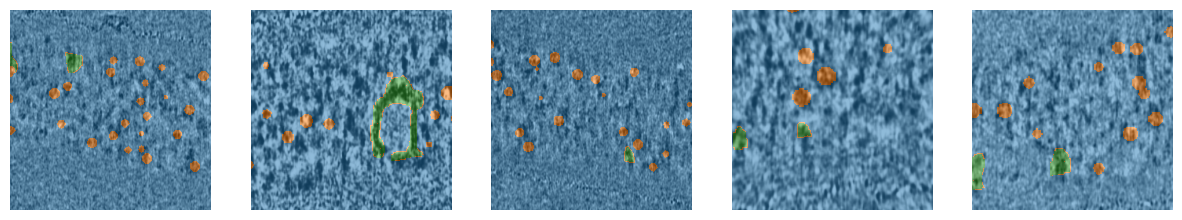

In [37]:
nimages=5
fig,axs = plt.subplots(1,nimages,figsize=(15,5))
for i, (datai,labeli) in enumerate(dataloaders_train[2]): # Change index to 0,1,2 for z,y,x
    print(f"i:{i}, datai shape:{datai.shape}, type:{datai.dtype}   label shape:{labeli.shape}, type:{labeli.dtype}")
    datai=datai.detach().cpu().numpy()[0,0,:,:]
    labeli = labeli.detach().cpu().numpy()[0,:,:]
    axs[i].imshow(datai, cmap="gray")
    axs[i].imshow(labeli,cmap='tab10', alpha=0.5, vmax=10)
    axs[i].set_axis_off()

    if i==nimages-1:
        break

looks ok

# setup loss function

In [38]:
nn1_loss_criterion

'DiceLoss'

In [39]:
nn1_loss_func_and_activ = None
activ = torch.nn.Sigmoid()
if "crossentropyloss" in nn1_loss_criterion.lower():
    #nn1_loss_func = torch.nn.CrossEntropyLoss().to(cuda_str) # expects logits!
    nn1_loss_func = smp.losses.SoftCrossEntropyLoss().to('cuda') # Not clear but I think it expects logits
    nn1_loss_func_and_activ= {"func":nn1_loss_func, "activ":activ}
elif "diceloss" in nn1_loss_criterion.lower():
    nn1_loss_func = smp.losses.DiceLoss(mode='multiclass', from_logits=True).to(cuda_str)
    nn1_loss_func_and_activ= {"func":nn1_loss_func, "activ":None}
else:
    raise ValueError(f"{nn1_loss_criterion} not a valid loss criteria")

In [40]:
nn1_loss_func_and_activ

{'func': DiceLoss(), 'activ': None}

# setup metric function

In [41]:
# Setup metrics for test data
nn1_metric_func = None
if "meaniou" in nn1_eval_metric.lower():
    nn1_metric_func = segmentation_models_pytorch.utils.metrics.IoU()
elif "dice" in nn1_eval_metric.lower() or "fscore" in nn1_eval_metric.lower():
    nn1_metric_func = segmentation_models_pytorch.utils.metrics.Fscore()
elif "accuracy" in nn1_eval_metric.lower():
    nn1_metric_func = segmentation_models_pytorch.utils.metrics.Accuracy()

In [42]:
nn1_metric_func

IoU(
  (activation): Activation(
    (activation): Identity()
  )
)

# Setup training of each model individually

train, test loops

In [43]:
def train_loop(dataloader, model, loss_func_and_activ, optimizer, scaler, scheduler, do_log=True):
    loss_fn = loss_func_and_activ["func"]
    activ_fn = loss_func_and_activ["activ"]
    
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #X=X_parse(X)
        # Compute prediction and loss
        pred = model(X)

        #y= y_parse(y) # to cuda
        loss = loss_fn(pred, y)
        if activ_fn is not None:
            loss = activ_fn(loss)

        # Backpropagation
        #loss.backward()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        #optimizer.step() #step done by the scheduler
        optimizer.zero_grad()

        scheduler.step()

        if do_log and batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            logging.info(f"batch:{batch}  loss: {loss:>7f}  [{current:>5d}/{size:>5d}]. lr:{scheduler.get_last_lr()}")

def test_loop(dataloader, model, loss_func_and_activ, metric_fn=None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    #size = len(dataloader.dataset)
    #num_batches = len(dataloader)

    loss_fn = loss_func_and_activ["func"]
    activ_fn = loss_func_and_activ["activ"]

    test_losses=[]
    test_metrics=[]

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            #X=X_parse(X)
            #y=y_parse(y)
            pred = model(X)

            loss = loss_fn(pred, y)
            if activ_fn is not None:
                loss = activ_fn(loss)
            test_loss = loss.item()
            test_losses.append(test_loss)

            if not metric_fn is None:
                pred_argmax = torch.argmax(pred, dim=1)
                metric = metric_fn(pred_argmax, y).item()
                test_metrics.append(metric)
            # #metric
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = np.mean(np.array(test_losses))
    logging.info(f"Avg loss: {avg_loss:>8f}")

    avg_metric=None
    if not metric_fn is None:
        avg_metric = np.mean(np.array(test_metrics))
        logging.info(f"Avg metric: {avg_metric:>8f}")

    return {"avg_loss":avg_loss, "avg_metric":avg_metric, "test_metrics":test_metrics, "test_losses":test_losses}

def train_model(model0, dl_train, dl_test, loss_fn, optimizer, scaler, scheduler, epochs, metric_fn=None):
    logging.info("train_model()")
    test_results=[]
    for t in range(epochs):
        logging.info(f"---- Epoch {t+1}/{epochs} ----")
        train_loop(dl_train, model0, loss_fn, optimizer, scaler, scheduler)
        test_res= test_loop(dl_test, model0, loss_fn, metric_fn=metric_fn)
        test_results.append(test_res)
    logging.info(f"Done! Final loss is : {test_res['avg_loss']}, and metric is: {test_res['avg_metric']}")
    return {"test_results": test_results}


In [44]:
print(len(NN1_models))
print(len(dataloaders_train))
print(len(dataloaders_test))

3
3
3


Train first model

In [45]:
model= NN1_models[0]
dl_train0 = dataloaders_train[0]
dl_test0 = dataloaders_test[0]

In [46]:
#Setup optimizer and scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=nn1_lr)
scaler=torch.cuda.amp.GradScaler()

epochs = nn1_epochs
#epochs = 10

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr= nn1_max_lr,
    steps_per_epoch=len(dl_train0),
    epochs=epochs,
    #pct_start=0.1, #default=0.3
    )

In [47]:
train_model(model, dl_train0, dl_test0, nn1_loss_func_and_activ, optimizer, scaler, scheduler,
            epochs=epochs,
            metric_fn=nn1_metric_func
            )

INFO:root:train_model()
INFO:root:---- Epoch 1/5 ----
INFO:root:batch:0  loss: 0.869582  [    2/  205]. lr:[0.001203015784623812]
INFO:root:batch:50  loss: 0.538641  [  102/  205]. lr:[0.008357503352799781]
INFO:root:batch:100  loss: 0.334255  [  202/  205]. lr:[0.022457052673650425]
INFO:root:Avg loss: 0.888416
INFO:root:Avg metric: 0.077146
INFO:root:---- Epoch 2/5 ----
INFO:root:batch:0  loss: 0.514353  [    2/  205]. lr:[0.023221115352931185]
INFO:root:batch:50  loss: 0.261649  [  102/  205]. lr:[0.0299998576071918]
INFO:root:batch:100  loss: 0.493088  [  202/  205]. lr:[0.028570741327914023]
INFO:root:Avg loss: 0.525015
INFO:root:Avg metric: 0.214542
INFO:root:---- Epoch 3/5 ----
INFO:root:batch:0  loss: 0.466940  [    2/  205]. lr:[0.02839905959041192]
INFO:root:batch:50  loss: 0.499086  [  102/  205]. lr:[0.02430118142516974]
INFO:root:batch:100  loss: 0.597307  [  202/  205]. lr:[0.018465172558590027]
INFO:root:Avg loss: 0.514548
INFO:root:Avg metric: 0.185825
INFO:root:---- Ep

{'test_results': [{'avg_loss': 0.888416166488941,
   'avg_metric': 0.077146374835538,
   'test_metrics': [0.1108536571264267,
    0.17127463221549988,
    0.1147884652018547,
    0.10979057848453522,
    0.0420406349003315,
    0.06829910725355148,
    0.13977138698101044,
    0.08980345726013184,
    0.04292193800210953,
    0.04277511686086655,
    0.11406299471855164,
    0.06427865475416183,
    0.08464861661195755,
    0.0716777890920639,
    0.07127939909696579,
    0.09008826315402985,
    0.12479940056800842,
    7.812316874140912e-13,
    7.812988537386767e-13,
    0.05416695773601532,
    0.112813800573349,
    0.06684504449367523,
    0.07192082703113556,
    0.08895345777273178,
    0.05795156583189964,
    1.5624756263127315e-12],
   'test_losses': [0.96293044090271,
    0.9489827156066895,
    0.9596084356307983,
    0.9039607048034668,
    0.9787547588348389,
    0.9780975580215454,
    0.963488757610321,
    0.9720058441162109,
    0.9663106799125671,
    0.981453895568

Prediction of some slices of first model

i:0, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:0, pred_max:0
i:1, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:1, pred_max:1
i:2, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:2, pred_max:2


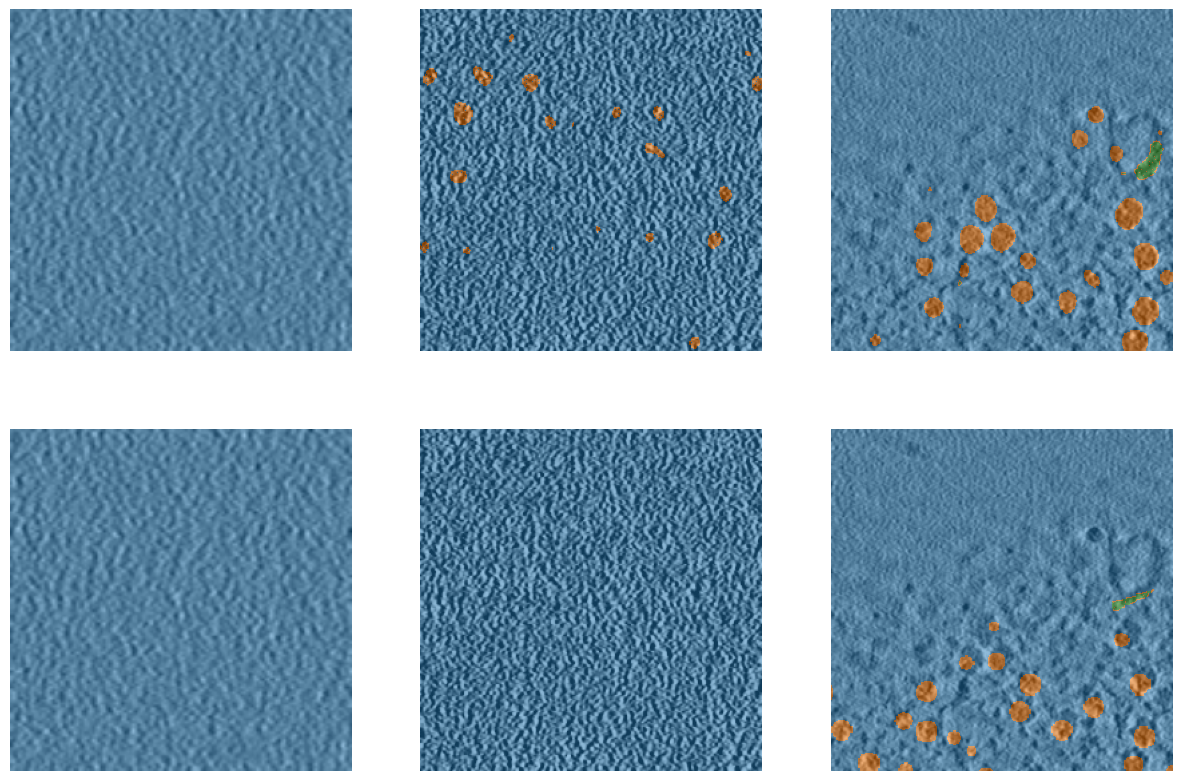

In [48]:
model= NN1_models[0]
dl_train0 = dataloaders_train[0]
dl_test0 = dataloaders_test[0]
model.eval()
nimages=3
fig,axs = plt.subplots(2,nimages,figsize=(15,10))
for i, (datai,labeli) in enumerate(dataloaders_train[0]):
    print(f"i:{i}, datai shape:{datai.shape}, type:{datai.dtype}   label shape:{labeli.shape}, type:{labeli.dtype}")
    #datai=datai.detach().cpu().numpy()[0,0,:,:]
    labeli = labeli.detach().cpu().numpy()[0,:,:]
    
    X=datai
    pred=model(X)
    pred_argmax = torch.argmax(pred, dim=1)

    pred_np = pred_argmax.detach().cpu().numpy()[0,:,:]
    print(f"i:{i}, pred_max:{pred_np.max()}")
    datai_np = datai.detach().cpu().numpy()[0,0,:,:]
    axs[0,i].imshow(datai_np, cmap="gray")
    axs[0,i].imshow(pred_np,cmap='tab10', alpha=0.5, vmax=10)
    axs[0,i].set_axis_off()

    axs[1,i].imshow(datai_np, cmap="gray")
    axs[1,i].imshow(labeli,cmap='tab10', alpha=0.5, vmax=10)
    axs[1,i].set_axis_off()

    if i==nimages-1:
        break

    #predictions on top, ground truth at the bottom

Not bad

Second model (Y axis) training

In [49]:
model= NN1_models[1]
dl_train0 = dataloaders_train[1]
dl_test0 = dataloaders_test[1]

In [50]:
#Setup optimizer and scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=nn1_lr)
scaler=torch.cuda.amp.GradScaler()

epochs = nn1_epochs
#epochs = 10

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr= nn1_max_lr,
    steps_per_epoch=len(dl_train0),
    epochs=epochs,
    #pct_start=0.1, #default=0.3
    )

In [51]:
train_model(model, dl_train0, dl_test0, nn1_loss_func_and_activ, optimizer, scaler, scheduler,
            epochs=epochs,
            metric_fn=nn1_metric_func
            )

INFO:root:train_model()
INFO:root:---- Epoch 1/5 ----
INFO:root:batch:0  loss: 0.454503  [    2/  205]. lr:[0.001203015784623812]
INFO:root:batch:50  loss: 0.563578  [  102/  205]. lr:[0.008357503352799781]
INFO:root:batch:100  loss: 0.532124  [  202/  205]. lr:[0.022457052673650425]
INFO:root:Avg loss: 0.605289
INFO:root:Avg metric: 0.167245
INFO:root:---- Epoch 2/5 ----
INFO:root:batch:0  loss: 0.546895  [    2/  205]. lr:[0.023221115352931185]
INFO:root:batch:50  loss: 0.530996  [  102/  205]. lr:[0.0299998576071918]
INFO:root:batch:100  loss: 0.548834  [  202/  205]. lr:[0.028570741327914023]
INFO:root:Avg loss: 0.580993
INFO:root:Avg metric: 0.200354
INFO:root:---- Epoch 3/5 ----
INFO:root:batch:0  loss: 0.572184  [    2/  205]. lr:[0.02839905959041192]
INFO:root:batch:50  loss: 0.535207  [  102/  205]. lr:[0.02430118142516974]
INFO:root:batch:100  loss: 0.564515  [  202/  205]. lr:[0.018465172558590027]
INFO:root:Avg loss: 0.533236
INFO:root:Avg metric: 0.184780
INFO:root:---- Ep

{'test_results': [{'avg_loss': 0.6052892529047452,
   'avg_metric': 0.16724455299285743,
   'test_metrics': [0.09177152067422867,
    0.1006210669875145,
    0.18970946967601776,
    0.1681569516658783,
    0.15392601490020752,
    0.12993121147155762,
    0.15278853476047516,
    0.1322665512561798,
    0.1974867284297943,
    0.1239965558052063,
    0.16140422224998474,
    0.14817531406879425,
    0.11702722311019897,
    0.20478612184524536,
    0.13359570503234863,
    0.17141099274158478,
    0.2056654989719391,
    0.392239511013031,
    0.18679992854595184,
    0.11930916458368301,
    0.20277974009513855,
    0.1631501168012619,
    0.2257685661315918,
    0.18519136309623718,
    0.10150358825922012,
    0.18889671564102173],
   'test_losses': [0.7098201513290405,
    0.7270601987838745,
    0.5643680095672607,
    0.5853899121284485,
    0.5942646265029907,
    0.6340086460113525,
    0.6563748121261597,
    0.6302623152732849,
    0.5605677366256714,
    0.6257321834564209,

Prediction of some slices of second model

i:0, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:0, pred_max:0
i:1, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:1, pred_max:2
i:2, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:2, pred_max:2


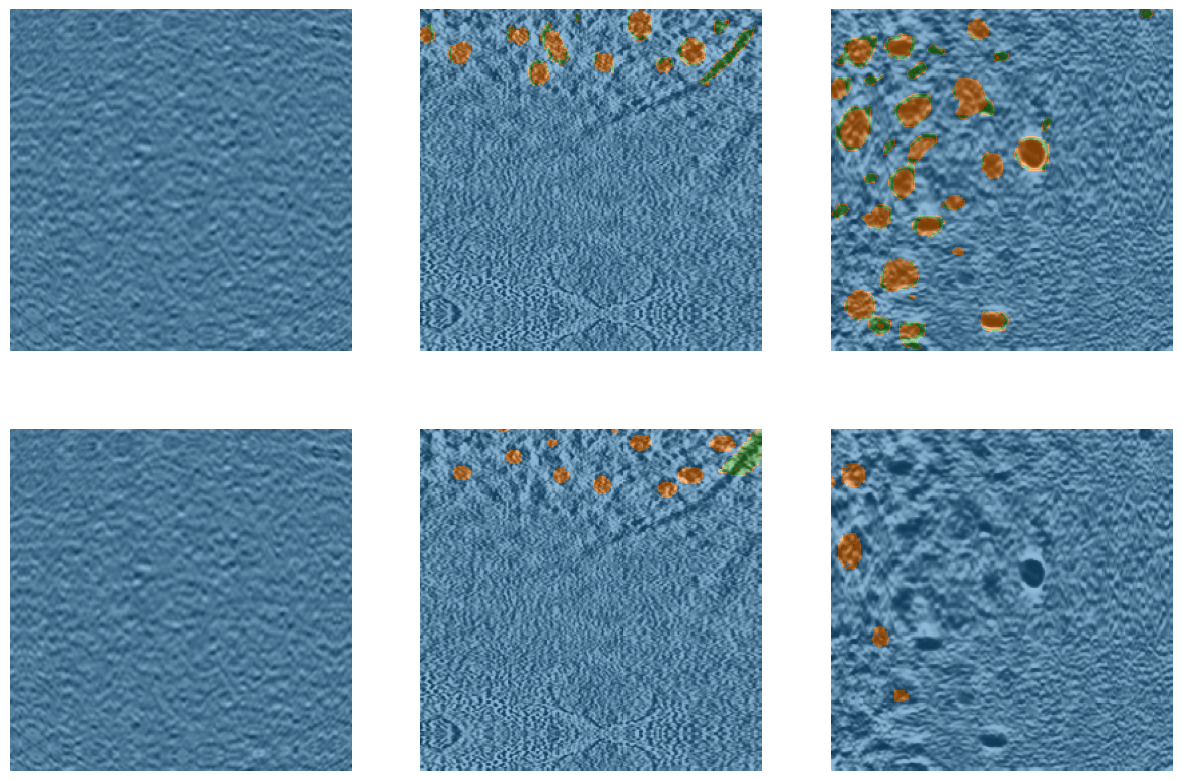

In [52]:
model= NN1_models[1]
dl_train0 = dataloaders_train[1]
dl_test0 = dataloaders_test[1]
model.eval()
nimages=3
fig,axs = plt.subplots(2,nimages,figsize=(15,10))
for i, (datai,labeli) in enumerate(dataloaders_train[0]):
    print(f"i:{i}, datai shape:{datai.shape}, type:{datai.dtype}   label shape:{labeli.shape}, type:{labeli.dtype}")
    #datai=datai.detach().cpu().numpy()[0,0,:,:]
    labeli = labeli.detach().cpu().numpy()[0,:,:]
    
    X=datai
    pred=model(X)
    pred_argmax = torch.argmax(pred, dim=1)

    pred_np = pred_argmax.detach().cpu().numpy()[0,:,:]
    print(f"i:{i}, pred_max:{pred_np.max()}")
    datai_np = datai.detach().cpu().numpy()[0,0,:,:]
    axs[0,i].imshow(datai_np, cmap="gray")
    axs[0,i].imshow(pred_np,cmap='tab10', alpha=0.5, vmax=10)
    axs[0,i].set_axis_off()

    axs[1,i].imshow(datai_np, cmap="gray")
    axs[1,i].imshow(labeli,cmap='tab10', alpha=0.5, vmax=10)
    axs[1,i].set_axis_off()

    if i==nimages-1:
        break

    #predictions on top, ground truth at the bottom

Third model (X axis) training

In [53]:
model= NN1_models[2]
dl_train0 = dataloaders_train[2]
dl_test0 = dataloaders_test[2]

In [54]:
#Setup optimizer and scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=nn1_lr)
scaler=torch.cuda.amp.GradScaler()

epochs = nn1_epochs
#epochs = 10

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr= nn1_max_lr,
    steps_per_epoch=len(dl_train0),
    epochs=epochs,
    #pct_start=0.1, #default=0.3
    )

In [55]:
train_model(model, dl_train0, dl_test0, nn1_loss_func_and_activ, optimizer, scaler, scheduler,
            epochs=epochs,
            metric_fn=nn1_metric_func
            )

INFO:root:train_model()
INFO:root:---- Epoch 1/5 ----
INFO:root:batch:0  loss: 0.796812  [    2/  205]. lr:[0.001203015784623812]
INFO:root:batch:50  loss: 0.599978  [  102/  205]. lr:[0.008357503352799781]
INFO:root:batch:100  loss: 0.563992  [  202/  205]. lr:[0.022457052673650425]
INFO:root:Avg loss: 0.736732
INFO:root:Avg metric: 0.119795
INFO:root:---- Epoch 2/5 ----
INFO:root:batch:0  loss: 0.565190  [    2/  205]. lr:[0.023221115352931185]
INFO:root:batch:50  loss: 0.556115  [  102/  205]. lr:[0.0299998576071918]
INFO:root:batch:100  loss: 0.535967  [  202/  205]. lr:[0.028570741327914023]
INFO:root:Avg loss: 0.594698
INFO:root:Avg metric: 0.178842
INFO:root:---- Epoch 3/5 ----
INFO:root:batch:0  loss: 0.532306  [    2/  205]. lr:[0.02839905959041192]
INFO:root:batch:50  loss: 0.571548  [  102/  205]. lr:[0.02430118142516974]
INFO:root:batch:100  loss: 0.559267  [  202/  205]. lr:[0.018465172558590027]
INFO:root:Avg loss: 0.637997
INFO:root:Avg metric: 0.155092
INFO:root:---- Ep

{'test_results': [{'avg_loss': 0.7367319877331073,
   'avg_metric': 0.11979524390055583,
   'test_metrics': [0.09916824847459793,
    0.20658041536808014,
    0.08049838989973068,
    0.0933271124958992,
    0.17797419428825378,
    0.12429492920637131,
    0.1193762943148613,
    0.11441514641046524,
    0.09562133997678757,
    0.15799984335899353,
    0.1392049640417099,
    0.13240842521190643,
    0.07974802702665329,
    0.09635327756404877,
    0.15791158378124237,
    0.10516956448554993,
    0.1152731254696846,
    0.0658593401312828,
    0.11685514450073242,
    0.10513773560523987,
    0.04019489884376526,
    0.15497146546840668,
    0.15001627802848816,
    0.19413980841636658,
    0.1096186712384224,
    0.08255811780691147],
   'test_losses': [0.82847660779953,
    0.743061900138855,
    0.7409266233444214,
    0.896050214767456,
    0.5651230216026306,
    0.7610893249511719,
    0.7036991119384766,
    0.6700867414474487,
    0.8446037173271179,
    0.6400771737098694,

Prediction of some slices of second model

i:0, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:0, pred_max:1
i:1, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:1, pred_max:1
i:2, datai shape:torch.Size([2, 1, 256, 256]), type:torch.float32   label shape:torch.Size([2, 256, 256]), type:torch.int64
i:2, pred_max:1


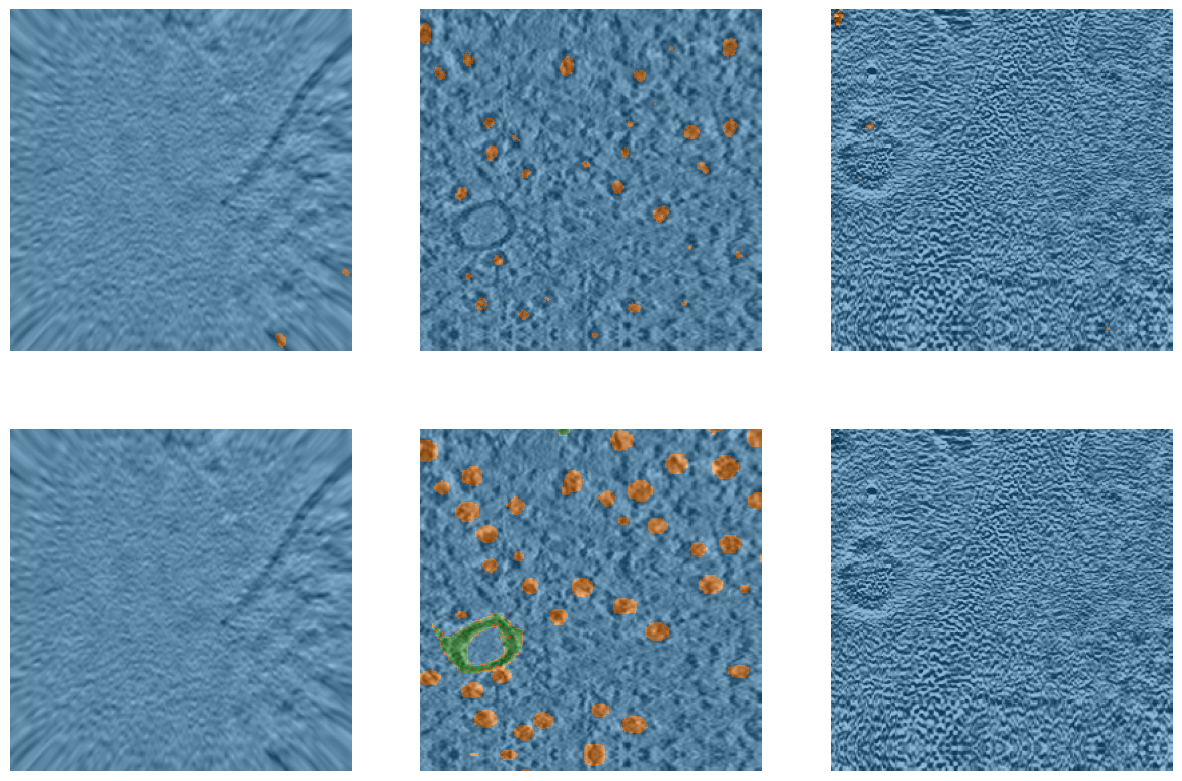

In [56]:
model= NN1_models[2]
dl_train0 = dataloaders_train[2]
dl_test0 = dataloaders_test[2]
model.eval()
nimages=3
fig,axs = plt.subplots(2,nimages,figsize=(15,10))
for i, (datai,labeli) in enumerate(dataloaders_train[0]):
    print(f"i:{i}, datai shape:{datai.shape}, type:{datai.dtype}   label shape:{labeli.shape}, type:{labeli.dtype}")
    #datai=datai.detach().cpu().numpy()[0,0,:,:]
    labeli = labeli.detach().cpu().numpy()[0,:,:]
    
    X=datai
    pred=model(X)
    pred_argmax = torch.argmax(pred, dim=1)

    pred_np = pred_argmax.detach().cpu().numpy()[0,:,:]
    print(f"i:{i}, pred_max:{pred_np.max()}")
    datai_np = datai.detach().cpu().numpy()[0,0,:,:]
    axs[0,i].imshow(datai_np, cmap="gray")
    axs[0,i].imshow(pred_np,cmap='tab10', alpha=0.5, vmax=10)
    axs[0,i].set_axis_off()

    axs[1,i].imshow(datai_np, cmap="gray")
    axs[1,i].imshow(labeli,cmap='tab10', alpha=0.5, vmax=10)
    axs[1,i].set_axis_off()

    if i==nimages-1:
        break

    #predictions on top, ground truth at the bottom

In [57]:
assert 1==0

AssertionError: 

NVIDIA RAM usage 1020MiB

# Predict volume(s) using the models

setup temporary folder to store the predicted volumes

In [58]:
tempdir_pred= tempfile.TemporaryDirectory()
tempdir_pred_path = Path(tempdir_pred.name)
logging.info(f"tempdir_pred_path:{tempdir_pred_path}")

INFO:root:tempdir_pred_path:C:\Users\LUIS-W~1\AppData\Local\Temp\tmpyclbjvv2


In [150]:
import h5py
def _save_pred_data(folder, data, count,axis, rot):
    # Saves predicted data to h5 file in tempdir and return file path in case it is needed
    file_path = f"{folder}/pred_{count}_{axis}_{rot}.h5"

    logging.info(f"Saving data of shape {data.shape} to {file_path}.")
    with h5py.File(file_path, "w") as f:
        f.create_dataset("/data", data=data)

    return file_path

In [60]:
data_to_predict = traindata_list[0] #Only first volume for testing.
# Volumes in traindata_list has already been normalised/clipped

In [61]:
class VolumeSlicerDataset(Dataset):

    def __init__(self, datavol, axis, per_slice_tfms=None, device_str="cuda:0"):
        assert datavol.ndim==3
        assert axis==0 or axis==1 or axis==2

        self.datavol=datavol
        self.axis=axis
        self.per_slice_tfms=per_slice_tfms
        self.device_str = device_str

    def __len__(self):
        return self.datavol.shape[self.axis]

    def __getitem__(self, idx):
        
        data_slice=None
        if self.axis==0:
            data_slice = self.datavol[idx,:,:]
        elif self.axis==1:
            data_slice = self.datavol[:,idx,:]
        elif self.axis==2:
            data_slice = self.datavol[:,:,idx]

        res = data_slice
        # Apply transform
        if self.per_slice_tfms is not None:
            res = self.per_slice_tfms(data_slice)

        #Convert to tensor and send to device
        res_torch = torch.unsqueeze(torch.from_numpy(res), dim=0).float().to(self.device_str)

        return res_torch

In [62]:
# Test
ds0 = VolumeSlicerDataset(data_to_predict, axis=0 , per_slice_tfms=None, device_str=cuda_str)

Visualise test dataset

i:0, datai shape:torch.Size([1, 256, 256]), dtype:torch.float32, type:<class 'torch.Tensor'>
i:1, datai shape:torch.Size([1, 256, 256]), dtype:torch.float32, type:<class 'torch.Tensor'>
i:2, datai shape:torch.Size([1, 256, 256]), dtype:torch.float32, type:<class 'torch.Tensor'>
i:3, datai shape:torch.Size([1, 256, 256]), dtype:torch.float32, type:<class 'torch.Tensor'>
i:4, datai shape:torch.Size([1, 256, 256]), dtype:torch.float32, type:<class 'torch.Tensor'>


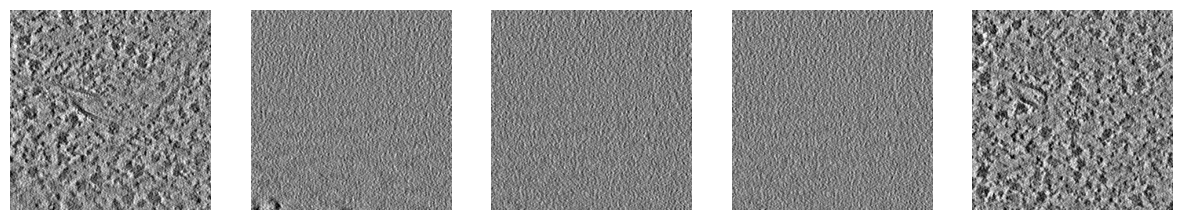

In [63]:
nimages=5
fig,axs = plt.subplots(1,nimages,figsize=(15,5))

randomints= np.random.default_rng().permutation(256)

for i in range(nimages):
    r0 = randomints[i]
    datai_t = ds0[r0]
    print(f"i:{i}, datai shape:{datai_t.shape}, dtype:{datai_t.dtype}, type:{type(datai_t)}")
    datai=datai_t.detach().cpu().numpy()[0,:,:]
    axs[i].imshow(datai, cmap="gray")
    axs[i].set_axis_off()

    if i==nimages-1:
        break

In [64]:
dl0 = DataLoader(dataset=ds0, batch_size=nn1_batch_size, shuffle=False)

In [65]:
#Use model0
model=NN1_models[0]

In [132]:
model.eval()

SM_func = torch.nn.Softmax(dim=1) # to get probabilities

Run predictions for the whole volume along axes previously specified

In [133]:
preds_list = []
labels_list = []
with torch.no_grad():
    for ibatch, x in enumerate(dl0):
        logging.info(f"ibatch: {ibatch} ")
        X= model(x)
        #logging.info(f"X.shape:{X.shape}")

        pred_probs_slice = SM_func(X)
        #logging.info(f"pred_probs_slice.shape:{pred_probs_slice.shape}")
        #preds_list.append(pred_probs_slice)

        # get labels using argmax
        lbl_slice = torch.argmax(pred_probs_slice, dim=1)
        #labels_list.append(lbl_slice)

        # need to move out from device, otherwise it uses too much RAM

        pred_probs_slice_np = pred_probs_slice.detach().cpu().numpy()
        lbl_slice_np = lbl_slice.detach().cpu().numpy().astype(np.uint8)

        preds_list.append(pred_probs_slice_np)
        labels_list.append(lbl_slice_np)

INFO:root:ibatch: 0 
INFO:root:ibatch: 1 
INFO:root:ibatch: 2 
INFO:root:ibatch: 3 
INFO:root:ibatch: 4 
INFO:root:ibatch: 5 
INFO:root:ibatch: 6 
INFO:root:ibatch: 7 
INFO:root:ibatch: 8 
INFO:root:ibatch: 9 
INFO:root:ibatch: 10 
INFO:root:ibatch: 11 
INFO:root:ibatch: 12 
INFO:root:ibatch: 13 
INFO:root:ibatch: 14 
INFO:root:ibatch: 15 
INFO:root:ibatch: 16 
INFO:root:ibatch: 17 
INFO:root:ibatch: 18 
INFO:root:ibatch: 19 
INFO:root:ibatch: 20 
INFO:root:ibatch: 21 
INFO:root:ibatch: 22 
INFO:root:ibatch: 23 
INFO:root:ibatch: 24 
INFO:root:ibatch: 25 
INFO:root:ibatch: 26 
INFO:root:ibatch: 27 
INFO:root:ibatch: 28 
INFO:root:ibatch: 29 
INFO:root:ibatch: 30 
INFO:root:ibatch: 31 
INFO:root:ibatch: 32 
INFO:root:ibatch: 33 
INFO:root:ibatch: 34 
INFO:root:ibatch: 35 
INFO:root:ibatch: 36 
INFO:root:ibatch: 37 
INFO:root:ibatch: 38 
INFO:root:ibatch: 39 
INFO:root:ibatch: 40 
INFO:root:ibatch: 41 
INFO:root:ibatch: 42 
INFO:root:ibatch: 43 
INFO:root:ibatch: 44 
INFO:root:ibatch: 45

In [134]:
len(preds_list)

128

In [135]:
preds_list_conc = np.concatenate(preds_list, axis=0)
preds_list_conc.shape

(256, 3, 256, 256)

In [136]:
#preds_z = np.swapaxes(np.concatenate(preds_list, axis=0),0,1)
preds_z = np.transpose(preds_list_conc, axes=(1,0,2,3))

In [137]:
preds_z.shape

(3, 256, 256, 256)

In [138]:
labels_pred_z = np.concatenate(labels_list, axis=0)

In [139]:
labels_pred_z.shape

(256, 256, 256)

view some z-slices and predictions

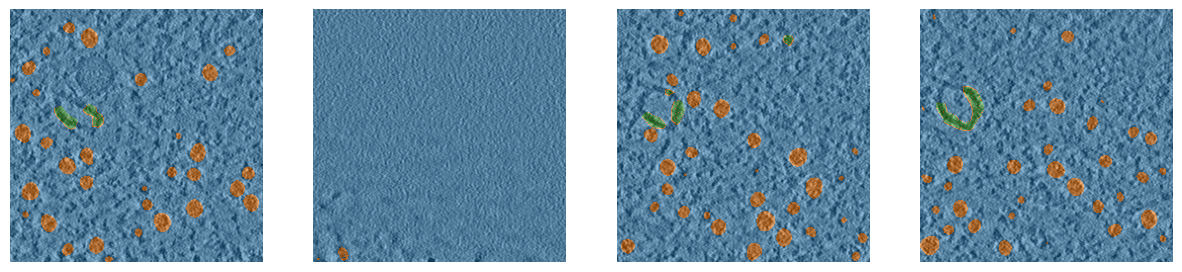

In [140]:
nimages=4
fig,axs = plt.subplots(1,nimages,figsize=(15,5))

randomints= np.random.default_rng().permutation(256)

for i in range(nimages):
    r0 = randomints[i]
    datai = data_to_predict[r0,:,:]
    labeli = labels_pred_z[r0,:,:]
    axs[i].imshow(datai, cmap="gray")
    axs[i].set_axis_off()
    axs[i].imshow(labeli , cmap='tab10', alpha=0.5, vmax=10)
    axs[i].set_axis_off()

OK

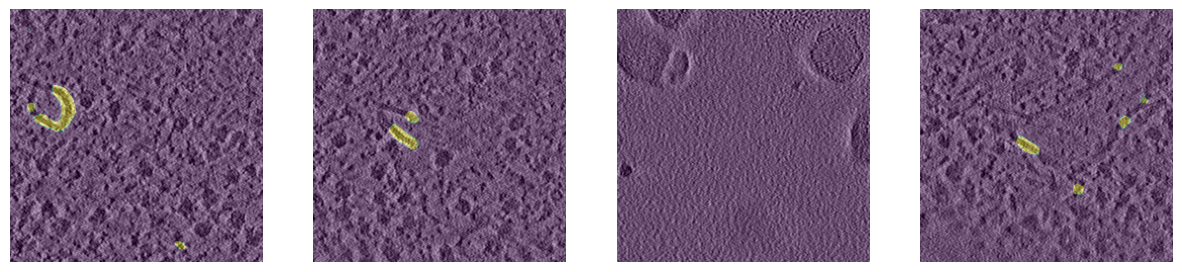

In [144]:
nimages=4
fig,axs = plt.subplots(1,nimages,figsize=(15,5))

randomints= np.random.default_rng().permutation(256)

for i in range(nimages):
    r0 = randomints[i]
    datai = data_to_predict[r0,:,:]
    predi = preds_z[2,r0,:,:]
    axs[i].imshow(datai, cmap="gray")
    axs[i].set_axis_off()
    axs[i].imshow(predi, cmap='viridis', alpha=0.4)
    axs[i].set_axis_off()

In [145]:
def nn1_predict_slices_along_axis(datavol, axis, device_str):
    ds0 = VolumeSlicerDataset(datavol, axis , per_slice_tfms=None, device_str=device_str)
    dl0 = DataLoader(dataset=ds0, batch_size=nn1_batch_size, shuffle=False)

    # Get correct model
    model_index = nn1_axes_to_models_indices[axis]
    model = NN1_models[model_index]
    logging.info(f"axis:{axis}, use model_index: {model_index}")

    model.eval()
    
    SM_func = torch.nn.Softmax(dim=1)

    preds_list = []
    labels_list = []
    for ibatch, x in enumerate(dl0):
        # x.shape is (batchsize, 1, 256,256) with 256 being the imagesize
        X= model(x)
        #pred shape is (batchsize, 3, 256, 256)

        pred_probs_slice = SM_func(X) #Convert to probabilities

        # get labels using argmax
        lbl_slice = torch.argmax(pred_probs_slice, dim=1)
        #labels_list.append(lbl_slice)

        # need to move away from device, otherwise it uses too much VRAM
        pred_probs_slice_np = pred_probs_slice.detach().cpu().numpy()
        lbl_slice_np = lbl_slice.detach().cpu().numpy().astype(np.uint8)

        preds_list.append(pred_probs_slice_np)
        labels_list.append(lbl_slice_np)

    logging.info("Prediction of all slices complete. Now stacking and getting the right orientation.")
    # stack slices
    preds_list_conc = np.concatenate(preds_list, axis=0) # shape will be (256,3,256,256)
    labels_pred_conc = np.concatenate(labels_list, axis=0)

    pred_oriented = None
    labels_oriented = None
    if axis==0:
        pred_oriented = np.transpose(preds_list_conc, axes=(1,0,2,3))
        labels_oriented = labels_pred_conc # no need to orient
    elif axis==1:
        pred_oriented = np.transpose(preds_list_conc, axes=(1,2,0,3))
        labels_oriented = np.transpose(labels_pred_conc, axes=(1,0,2))
    elif axis==2:
        pred_oriented = np.transpose(preds_list_conc, axes=(1,2,3,0))
        labels_oriented = np.transpose(labels_pred_conc, axes=(1,2,0))

    #with pred_oriented note that class probability is at the start
    return pred_oriented, labels_oriented

In [146]:
# test
res = nn1_predict_slices_along_axis(data_to_predict, axis=2, device_str=cuda_str)

INFO:root:axis:2, use model_index: 2
INFO:root:Prediction of all slices complete. Now stacking and getting the right orientation.


In [126]:
import napari
NV=napari.Viewer()
NV.add_image(data_to_predict)
NV.add_labels(res[1])
NV.add_labels(trainlabels_list[0])

<Labels layer 'Labels [1]' at 0x21fa0dae750>

In [147]:
import napari
NV=napari.Viewer()
NV.add_image(data_to_predict)
NV.add_image(res[0][1,...])

<Image layer 'Image' at 0x21fa1ba8b90>

## Several volumes, different rotations and axis and save

In [164]:
pred_data_probs_filenames=[] #Will store results in files, and keep the filenames as reference
pred_data_labels_filenames=[]
pred_sets=[]
pred_planes=[]
pred_rots=[]
pred_ipred=[]
pred_shapes=[]
itag=0
iset=0

for krot in range(0, 4): #Around axis rotations
    rot_angle_degrees = krot * 90
    logging.info(f"Volume to be rotated by {rot_angle_degrees} degrees")

    #Predict 3 axis
    #YX, along Z
    # planeYX=(1,2)
    logging.info("Predicting YX slices, along Z")
    data_vol = np.array(np.rot90(data_to_predict,krot, axes=(1,2))) #rotate

    prob0,lab0 = nn1_predict_slices_along_axis(data_vol, axis=0, device_str=cuda_str)

    #invert rotations before saving
    pred_probs = np.rot90(prob0, -krot, axes=(2,3)) 
    pred_labels = np.rot90(lab0, -krot, axes=(1,2)) #note that class is at start

    fn = _save_pred_data(tempdir_pred_path,pred_probs, iset, "YX", rot_angle_degrees)
    fn = _save_pred_data(tempdir_pred_path,pred_labels, iset, "YX_labels", rot_angle_degrees)

    pred_data_labels_filenames.append(fn)
    pred_data_probs_filenames.append(fn)
    pred_sets.append(iset)
    pred_planes.append("YX")
    pred_rots.append(rot_angle_degrees)
    pred_ipred.append(itag)
    pred_shapes.append(pred_labels.shape)
    itag+=1



    #ZX
    logging.info("Predicting ZX slices, along Y")
    #planeZX=(0,2)
    data_vol = np.array(np.rot90(data_to_predict,krot, axes=(0,2))) #rotate
    prob0,lab0 = nn1_predict_slices_along_axis(data_vol, axis=1, device_str=cuda_str)

    pred_probs = np.rot90(prob0, -krot, axes=(1,3)) #invert rotation before saving
    pred_labels = np.rot90(lab0, -krot, axes=(0,2))

    fn = _save_pred_data(tempdir_pred_path,pred_probs, iset, "ZX", rot_angle_degrees)
    fn = _save_pred_data(tempdir_pred_path,pred_labels, iset, "ZX_labels", rot_angle_degrees)

    pred_data_labels_filenames.append(fn)
    pred_data_probs_filenames.append(fn)
    pred_sets.append(iset)
    pred_planes.append("ZX")
    pred_rots.append(rot_angle_degrees)
    pred_ipred.append(itag)
    pred_shapes.append(pred_labels.shape)
    itag+=1



    #ZY
    logging.info("Predicting ZY slices, along X")
    #planeZY=(0,1)
    data_vol = np.array(np.rot90(data_to_predict,krot, axes=(0,1))) #rotate
    prob0,lab0 = nn1_predict_slices_along_axis(data_vol, axis=2, device_str=cuda_str)

    pred_probs = np.rot90(prob0, -krot, axes=(1,2)) #invert rotation before saving
    pred_labels = np.rot90(lab0, -krot, axes=(0,1))
    fn = _save_pred_data(tempdir_pred_path,pred_probs, iset, "ZY", rot_angle_degrees)
    fn = _save_pred_data(tempdir_pred_path,pred_labels, iset, "ZY_labels", rot_angle_degrees)

    pred_data_labels_filenames.append(fn)
    pred_data_probs_filenames.append(fn)
    pred_sets.append(iset)
    pred_planes.append("ZY")
    pred_rots.append(rot_angle_degrees)
    pred_ipred.append(itag)
    pred_shapes.append(pred_labels.shape)
    itag+=1

INFO:root:Volume to be rotated by 0 degrees
INFO:root:Predicting YX slices, along Z
INFO:root:axis:0, use model_index: 0
INFO:root:Prediction of all slices complete. Now stacking and getting the right orientation.
INFO:root:Saving data of shape (3, 256, 256, 256) to C:\Users\LUIS-W~1\AppData\Local\Temp\tmpyclbjvv2/pred_0_YX_0.h5.
INFO:root:Saving data of shape (256, 256, 256) to C:\Users\LUIS-W~1\AppData\Local\Temp\tmpyclbjvv2/pred_0_YX_labels_0.h5.
INFO:root:Predicting ZX slices, along Y
INFO:root:axis:1, use model_index: 1
INFO:root:Prediction of all slices complete. Now stacking and getting the right orientation.
INFO:root:Saving data of shape (3, 256, 256, 256) to C:\Users\LUIS-W~1\AppData\Local\Temp\tmpyclbjvv2/pred_0_ZX_0.h5.
INFO:root:Saving data of shape (256, 256, 256) to C:\Users\LUIS-W~1\AppData\Local\Temp\tmpyclbjvv2/pred_0_ZX_labels_0.h5.
INFO:root:Predicting ZY slices, along X
INFO:root:axis:2, use model_index: 2
INFO:root:Prediction of all slices complete. Now stacking a

Saved predictions to folder `C:\Users\LUIS-W~1\AppData\Local\Temp\tmpyclbjvv2/ `

Collect information to a pandas table

In [166]:
all_pred_pd = pd.DataFrame({
    'pred_data_probs_filenames': pred_data_probs_filenames,
    'pred_data_labels_filenames': pred_data_labels_filenames,
    'pred_sets':pred_sets,
    'pred_planes':pred_planes,
    'pred_rots':pred_rots,
    'pred_ipred':pred_ipred,
    'pred_shapes': pred_shapes,
        })

Save pandas table in case we need to exit before training NN2

In [167]:
all_pred_pd.to_csv("developing_segmentor2_nn1_temp_results.csv")

# NN2 training

Can restart kernel


TODO

In [ ]:
assert 1==0

In [ ]:

nn2_MLP_models_class_generator = {
    "nn2_hidden_layer_sizes" : "10,10",
    "nn2_activation": 'tanh',
    "nn2_out_nclasses": nclasses
    }


In [ ]:



    sett2.nn1_axes_to_models_indices = [0,1,2]

    sett2.nn2_MLP_models_class_generator = nn2_MLP_models_class_generator

    sett2.cuda_device = cuda_device #Probably should use kwargs

    #Create instance of cMultiAxisRotationsSegmentor2
    segm2 = cMultiAxisRotationsSegmentor2(sett2) # will run init()

    return segm2